<a href="https://colab.research.google.com/github/juhumkwon/Defense_Cloud/blob/main/Yolo_mnist_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Epoch 1
Step 0, Loss: 320.1004
Step 50, Loss: 24.0904
Step 100, Loss: 12.4283
Step 150, Loss: 10.7316

Epoch 2
Step 0, Loss: 8.7983
Step 50, Loss: 8.1971
Step 100, Loss: 7.1898
Step 150, Loss: 5.5005

Epoch 3
Step 0, Loss: 5.5326
Step 50, Loss: 5.2948
Step 100, Loss: 4.8625
Step 150, Loss: 3.9257


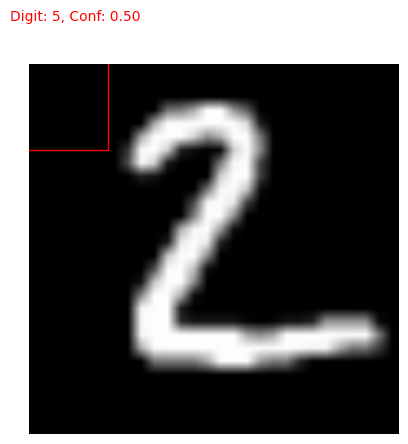

In [1]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model

# 설정
S = 7  # Grid 크기
A = 2  # Anchor box 개수
C = 10 # 클래스 수
IMG_SIZE = 224
ANCHORS = tf.constant([[0.3, 0.3], [0.5, 0.5]])  # (w, h) 비율

# 데이터 전처리
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

def preprocess_with_anchors(x, y):
    x = tf.image.resize(tf.expand_dims(x, -1), (IMG_SIZE, IMG_SIZE)) / 255.0
    x = tf.image.grayscale_to_rgb(x)
    target = np.zeros((S, S, A, 5 + C), dtype=np.float32)

    box_w = 28 / IMG_SIZE
    box_h = 28 / IMG_SIZE
    cx = 0.5
    cy = 0.5
    grid_x = int(cx * S)
    grid_y = int(cy * S)

    ious = []
    for aw, ah in ANCHORS:
        inter = min(box_w, aw) * min(box_h, ah)
        union = box_w * box_h + aw * ah - inter
        ious.append(inter / union)
    best_anchor = np.argmax(ious)

    tx = cx * S - grid_x
    ty = cy * S - grid_y
    tw = np.log(box_w / ANCHORS[best_anchor][0] + 1e-6)
    th = np.log(box_h / ANCHORS[best_anchor][1] + 1e-6)

    target[grid_y, grid_x, best_anchor, 0:4] = [tx, ty, tw, th]
    target[grid_y, grid_x, best_anchor, 4] = 1.0
    target[grid_y, grid_x, best_anchor, 5 + y] = 1.0
    return x, target

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(lambda x, y: tf.py_function(preprocess_with_anchors, [x, y], [tf.float32, tf.float32]))
train_ds = train_ds.map(lambda x, y: (tf.reshape(x, [IMG_SIZE, IMG_SIZE, 3]), tf.reshape(y, [S, S, A, 5 + C])))
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# 모델 정의
def build_yolov2(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(S * S * A * (5 + C))(x)
    outputs = layers.Reshape((S, S, A, 5 + C))(x)
    return Model(inputs, outputs)

# 손실 함수
def yolov2_loss(y_true, y_pred):
    lambda_coord = 5.0
    lambda_noobj = 0.5
    object_mask = y_true[..., 4:5]
    noobj_mask = 1.0 - object_mask

    pred_xy = tf.sigmoid(y_pred[..., 0:2])
    pred_wh = y_pred[..., 2:4]
    true_xy = y_true[..., 0:2]
    true_wh = y_true[..., 2:4]

    coord_loss = lambda_coord * tf.reduce_sum(object_mask * tf.square(true_xy - pred_xy))
    wh_loss = lambda_coord * tf.reduce_sum(object_mask * tf.square(true_wh - pred_wh))
    conf_loss_obj = tf.reduce_sum(object_mask * tf.square(1.0 - y_pred[..., 4:5]))
    conf_loss_noobj = lambda_noobj * tf.reduce_sum(noobj_mask * tf.square(y_pred[..., 4:5]))
    class_loss = tf.reduce_sum(object_mask * tf.square(y_true[..., 5:] - y_pred[..., 5:]))

    return coord_loss + wh_loss + conf_loss_obj + conf_loss_noobj + class_loss

# 학습 루프
@tf.function
def train_step(model, images, targets, optimizer):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = yolov2_loss(targets, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# 시각화
def decode_and_draw(image, pred, threshold=0.5):
    image = image.numpy()
    pred = tf.reshape(pred, (S, S, A, 5 + C)).numpy()
    h, w = IMG_SIZE, IMG_SIZE
    for i in range(S):
        for j in range(S):
            for a in range(A):
                conf = tf.sigmoid(pred[i, j, a, 4])
                if conf < threshold:
                    continue
                tx, ty, tw, th = pred[i, j, a, 0:4]
                bx = (j + tf.sigmoid(tx)) / S * w
                by = (i + tf.sigmoid(ty)) / S * h
                bw = ANCHORS[a][0] * tf.exp(tw) * w
                bh = ANCHORS[a][1] * tf.exp(th) * h
                class_id = np.argmax(pred[i, j, a, 5:])
                fig, ax = plt.subplots()
                ax.imshow(image)
                rect = plt.Rectangle((bx - bw/2, by - bh/2), bw, bh, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                ax.text(bx - bw/2, by - bh/2 - 5, f"Digit: {class_id}, Conf: {conf:.2f}", color='red')
                plt.axis('off')
                plt.show()
                return

# 모델 학습 실행
model = build_yolov2()
optimizer = tf.keras.optimizers.Adam(1e-4)

for epoch in range(3):
    print(f"\nEpoch {epoch+1}")
    for step, (images, targets) in enumerate(train_ds.take(200)):
        loss = train_step(model, images, targets, optimizer)
        if step % 50 == 0:
            print(f"Step {step}, Loss: {loss.numpy():.4f}")

# 예측 시각화
test_img = x_test[1]
img_resized = tf.image.resize(tf.expand_dims(test_img, -1), (IMG_SIZE, IMG_SIZE)) / 255.0
img_rgb = tf.image.grayscale_to_rgb(img_resized)
pred = model(tf.expand_dims(img_rgb, 0), training=False)[0]
decode_and_draw(img_rgb, pred)